In [1]:
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

In [2]:
import os

os.chdir("..")
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

In [3]:
import matplotlib.pyplot as plt

from orthogonal_dfa.oracle.evaluate import (
    conditional_mutual_information_from_log_confusion,
    evaluate_pdfas,
)
from orthogonal_dfa.spliceai.load_model import load_spliceai
from orthogonal_dfa.data.exon import default_exon
from orthogonal_dfa.manual_dfa.stop_codon_dfa import (
    stop_codon_from_psams,
    stop_codon_psamdfa,
    ZeroProbability,
)
import tqdm.auto as tqdm
from orthogonal_dfa.oracle.run_model import create_dataset

from orthogonal_dfa.utils.dfa import p_to_al

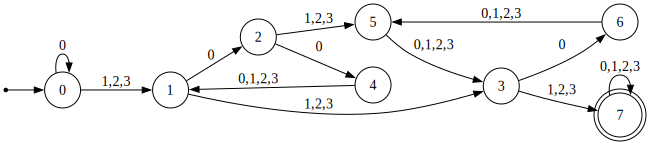

In [4]:
p_to_al(stop_codon_from_psams(3))

In [5]:
oracle = load_spliceai(400, 0).cuda()

In [6]:
random, hard_target = create_dataset(default_exon, oracle, count=100_000, seed=0)

In [7]:
no_orf = stop_codon_psamdfa("TAG", "TAA", "TGA", zero_prob=ZeroProbability(1e-7)).cuda()
no_orf_ta = stop_codon_psamdfa("TAG", "TAA", zero_prob=ZeroProbability(1e-7)).cuda()
three_stops = stop_codon_psamdfa(
    "TAG", "TAA", "TGA", zero_prob=ZeroProbability(1e-7), phase_agnostic=True
).cuda()
three_stops_ta = stop_codon_psamdfa(
    "TAG", "TAA", zero_prob=ZeroProbability(1e-7), phase_agnostic=True
).cuda()

settings = {
    "no-ORF": (no_orf,),
    "no-ORF-TA": (no_orf_ta,),
    "no-ORF | no-ORF-TA": (no_orf, no_orf_ta),
    "3S": (three_stops,),
    "3S-TA": (three_stops_ta,),
    "no-ORF | 3S": (no_orf, three_stops),
    "no-ORF-TA | 3S": (no_orf_ta, three_stops),
    "no-ORF | 3S-TA": (no_orf, three_stops_ta),
    "no-ORF-TA | 3S-TA": (no_orf_ta, three_stops_ta),
}

In [8]:
conf = {
    k: evaluate_pdfas(default_exon, test, control, oracle, seed=0)
    for (k, (test, *control)) in tqdm.tqdm(settings.items(), delay=5)
}
mi = {
    k: conditional_mutual_information_from_log_confusion(c)[0] for k, c in conf.items()
}

In [12]:
import numpy as np

In [15]:
np.exp(conf["no-ORF"])

array([[[0.03066017, 0.11468003],
        [0.4870298 , 0.3676301 ]]], dtype=float32)

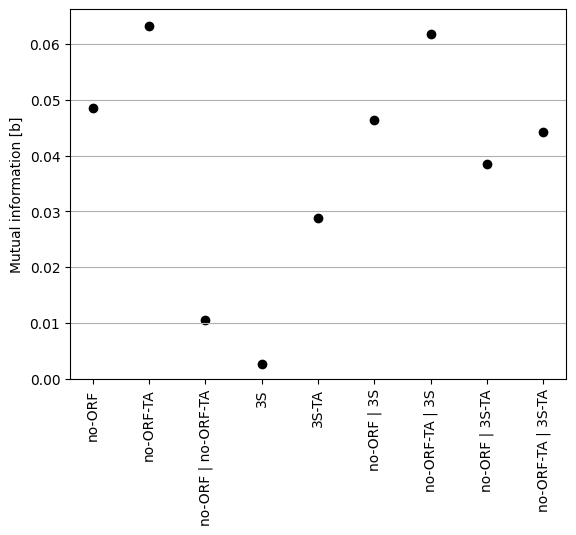

In [13]:
conditions = list(mi)
plt.scatter(range(len(conditions)), [mi[cond] for cond in conditions], color="black")
plt.ylim(0, plt.ylim()[1])
plt.ylabel("Mutual information [b]")
plt.xticks(range(len(conditions)), list(conditions), rotation=90)
plt.grid(axis="y")
plt.show()